# nema3 PDE=0.3, sigmaT = 50 ps, LXe = 40 mm phot quartz 

- Phantom : nema 3
- Events: phot
- Detector geometry: SiPMs in LXe, with Hamamatsu sipms + quartz
- Time resolution: 50 ps
- qcut > 3 pes ? old scheme
- ntof > 7
- PDE = 0.3
- LXe = 40 mm

In [1]:
using Pkg
Pkg.activate(normpath(joinpath(@__DIR__, "..")))  #activate environment in ,,/src

In [2]:
using Plots
using DataFrames
using HDF5
using PhysicalConstants
using PhysicalConstants.CODATA2018
using Unitful

In [3]:
using Glob
using CSV

In [4]:
using Statistics
using StatsBase
using Printf

In [5]:
using Logging

In [6]:
using ATools

In [7]:
include("../src/ANema.jl") 

Main.ANema

In [8]:
println(names(ATools))

[:ATools, :centers, :dxyz, :edges, :find_max_xy, :fit, :fit_gauss, :fit_gauss_fm, :fit_pol1, :fit_pol2, :fit_pol3, :fit_profile, :fitg1, :fitg2, :fphi, :hist1d, :hist2d, :in_range, :mean_std, :p1df, :phixy, :rxy, :select_by_column_value, :select_by_column_value_closed_interval, :select_by_column_value_closed_left_interval, :select_by_column_value_closed_right_interval, :select_by_column_value_ge, :select_by_column_value_gt, :select_by_column_value_interval, :select_by_column_value_le, :select_by_column_value_lt, :select_by_index, :select_event, :wstd]


In [9]:
println(names(ANema))

[:ANema, :cdoi, :crt, :ctsr, :deltatime, :dftolor, :radial_correcction, :readdf, :selectinterval, :setunits, :write_lors_hdf5, :writemdf]


In [10]:
import Unitful:
    nm, μm, mm, cm, ns, μs, ms, ps, s

In [11]:
function loglevel(log)
    if log == "Debug"
        logger = SimpleLogger(stdout, Logging.Debug)
    elseif log =="Info"
        logger = SimpleLogger(stdout, Logging.Info)
    else
        logger = SimpleLogger(stdout, Logging.Warn)
    end
    old_logger = global_logger(logger)
end

loglevel (generic function with 1 method)

## NB functions
- These are specific for plotting and are better kept in the NB

In [12]:
loglevel("Warn")

Base.CoreLogging.SimpleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(44) open, 0 bytes waiting))), Info, Dict{Any, Int64}())

# Notebook

In [13]:
norm = 1.0e+6
dir = "../data/"
dirp = "../plots"
conf = "n3-phot-quartz"
out = string(conf, "-mdf")
path = joinpath(dir, conf)
pathp = joinpath(dirp, conf)
patho = joinpath(dir, out)

if isdir(pathp) == false
    mkdir(pathp)
end

if isdir(patho) == false
    mkdir(patho)
end
println("input dir ", path)
println("plots in ", pathp)
println("merged DF in ", patho)

input dir ../data/n3-phot-quartz
plots in ../plots/n3-phot-quartz
merged DF in ../data/n3-phot-quartz-mdf


In [14]:

ndf = ANema.readdf(path) 
println("data frame has length of ", nrow(ndf), " fraction =", nrow(ndf)/norm)
println("data frame names ", names(ndf))

data frame has length of 72773 fraction =0.072773
data frame names ["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2"]


## q1 vs q2

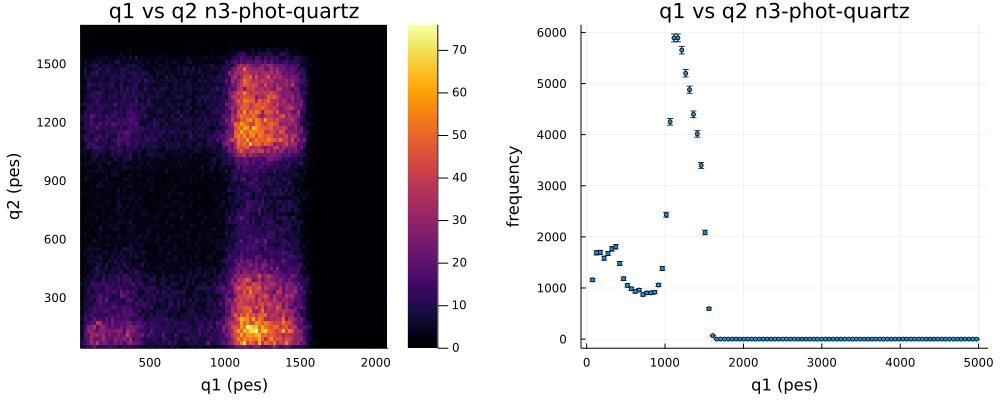

In [15]:
ANema.ANema.q1vsq2(ndf, tit="q1 vs q2 $conf", filename=joinpath(pathp, "q1q2"), save=true)

## Cut in (q1,q2) 

In [16]:
ndfq =ANema.selectinterval(ndf, "q1", "q2", 900.0, 1600.0);
println("after q1q2 cut: ndfq has a length of ", nrow(ndfq), " fraction = ", nrow(ndfq)/norm)

after q1q2 cut: ndfq has a length of 25202 fraction = 0.025202


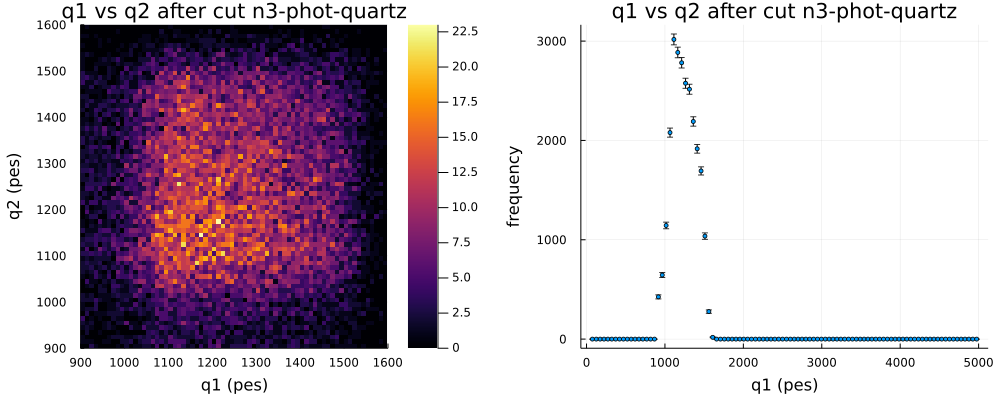

In [17]:
ANema.q1vsq2(ndfq, tit="q1 vs q2 after cut $conf", 
filename=joinpath(pathp, "q1q2-qcut"), save=true)

## r vs q

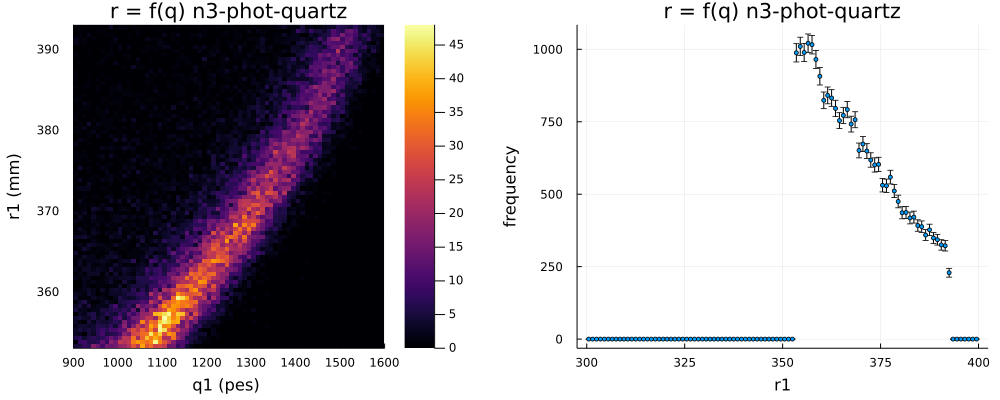

In [18]:
ANema.r1q1(ndfq,tit="r = f(q) $conf", filename=joinpath(pathp, "rq"), save=true)

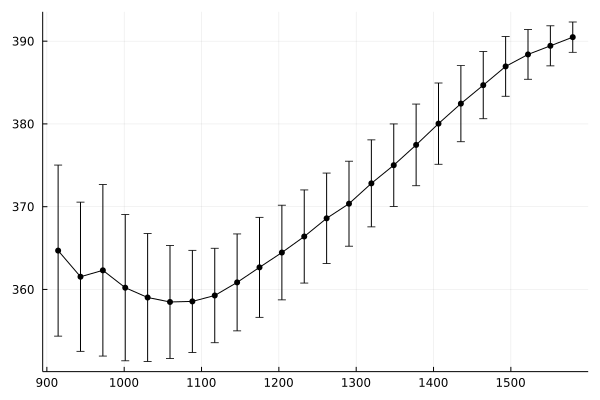

In [19]:
dfp, p1 = p1df(ndfq.q1, ndfq.r1, 25)
plot(p1)

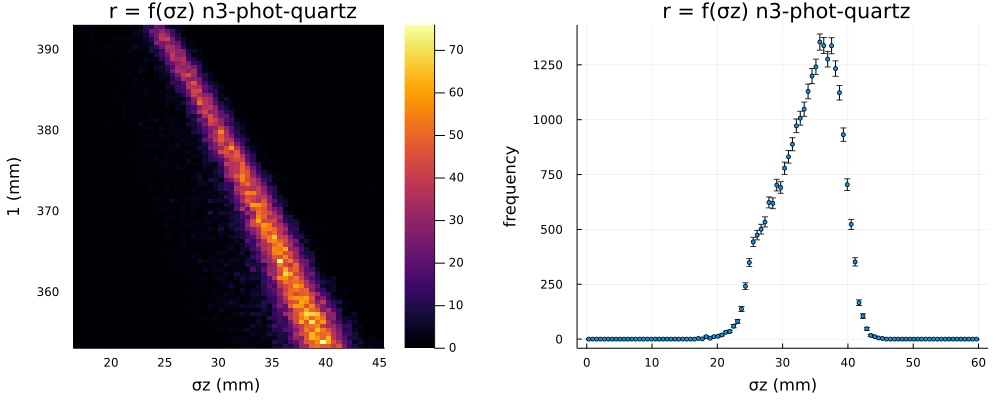

In [22]:
ANema.zstd(ndfq, 100, 0.0, 60.0, tit=" r = f(σz) $conf", filename=joinpath(pathp, "zstd"), save=true)

In [23]:
ndfz =ANema.selectinterval(ndfq, "zstd1", "zstd2", 20.0, 40.0);
println("after zstd cut: ndfz has a length of ", nrow(ndfz), " fraction =", nrow(ndfz)/norm )

after zstd cut: ndfz has a length of 22381 fraction =0.022381


Fit parameters: a = 360.00 b =  3.05 c = -0.081 Fit errors: a = 1e+01 b =  0.77 c = 0.013

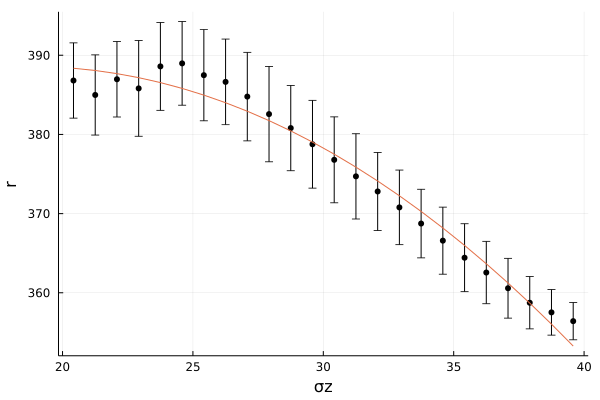

In [24]:
fz2, pz2 = fit_profile(ndfz.zstd1, ndfz.r1, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pz2, joinpath(pathp, "zstd-fitpol2"))
plot(pz2)

Fit parameters: a = 360.00 b =  3.05 c = -0.081 Fit errors: a = 1e+01 b =  0.77 c = 0.013

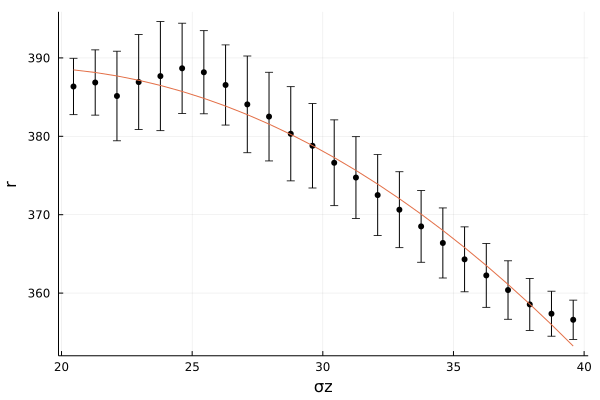

In [25]:
fzr2, pzr2 = fit_profile(ndfz.zstd2, ndfz.r2, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr2)

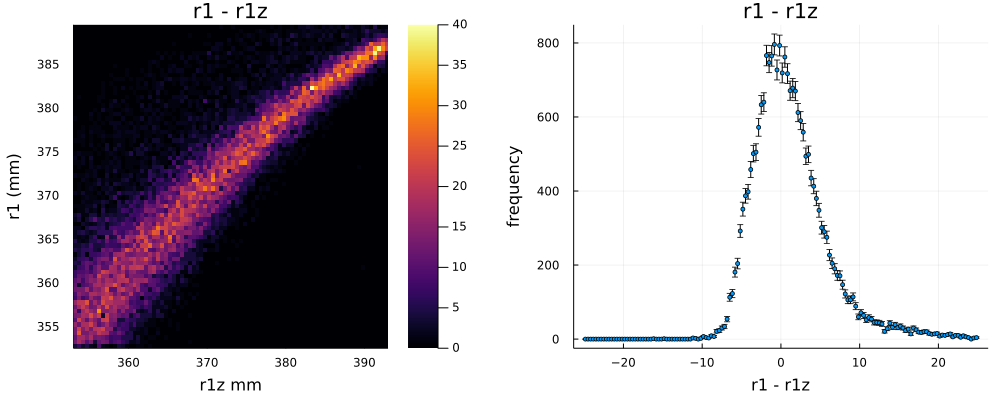

In [31]:
r1z = fz2.g.(ndfz.zstd1) + 1.0 * ones(length(ndfz.q1)) ; 
ANema.plotreso(r1z, ndfz.r1, "r1z mm", "r1 (mm)", -25., 25.0, tit="r1 - r1z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


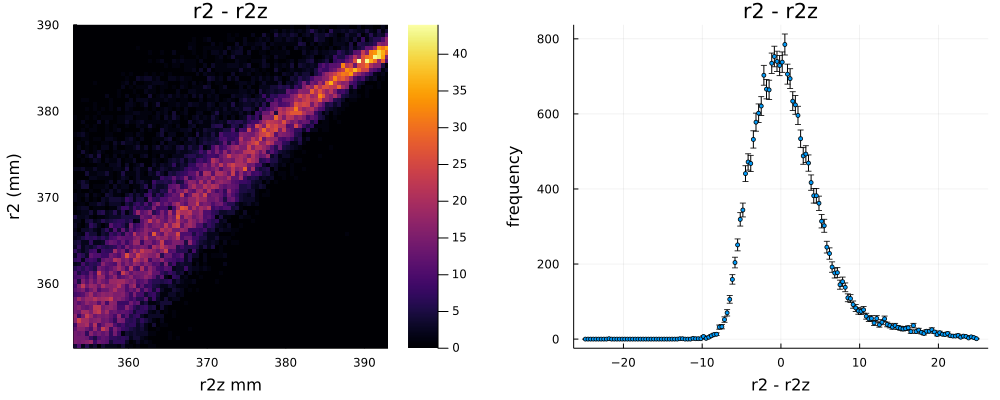

In [32]:
r2z = fzr2.g.(ndfz.zstd2) + 1.0 * ones(length(ndfz.q2)) 
ANema.plotreso(r2z, ndfz.r2, "r2z mm", "r2 (mm)", -25., 25.0, tit="r2 - r2z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


 σ =     3.7 mm

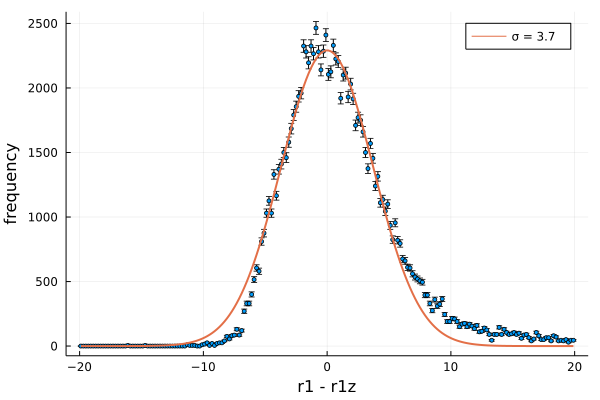

In [33]:
fg,p = fitg1(r1z - ndfz.r1, "r1 - r1z", 200, -20.0, 20.0, xgmin=-10.0, xgmax=10.0)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "zstd-fitg1"))
plot(p)

Fit parameters: a = 360.00 b =  3.05 c = -0.081 Fit errors: a = 1e+01 b =  0.77 c = 0.013

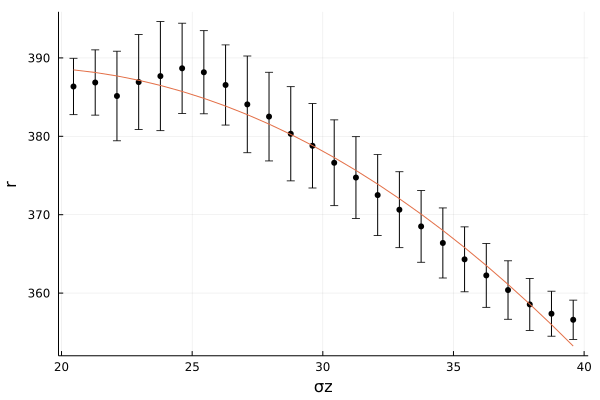

In [34]:
fzr2, pzr2 = fit_profile(ndfz.zstd2, ndfz.r2, "σz", "r", "pol2")
fpars = fz2.fitpar
fstds = fz2.fitstd
@printf "Fit parameters: a = %5.2f b = %5.2f c = %5.2g " fpars[1] fpars[2] fpars[3]
@printf "Fit errors: a = %5.1g b = %5.2g c = %5.2g" fstds[1] fstds[2] fstds[3]
ANema.pout(pzr2,joinpath(pathp, "zstd-fitpol2"))
plot(pzr2)

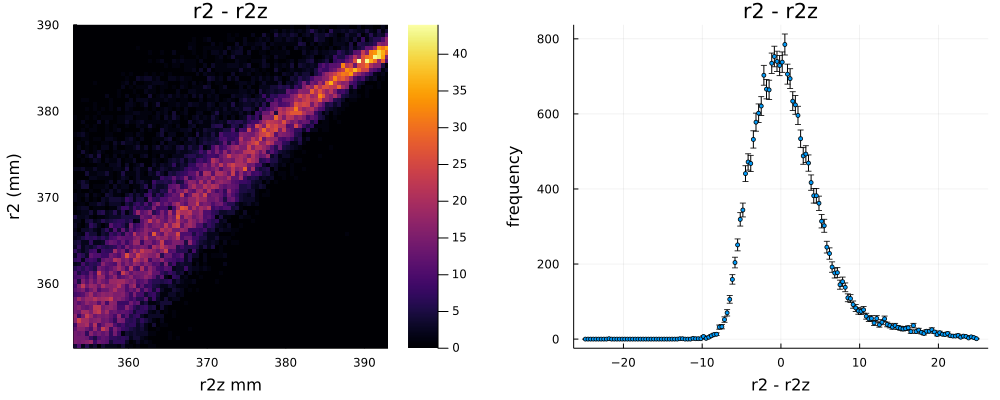

In [35]:
r2z = fzr2.g.(ndfz.zstd2) +1.0 * ones(length(ndfz.q2)) 
ANema.plotreso(r2z, ndfz.r2, "r2z mm", "r2 (mm)", -25., 25.0, tit="r2 - r2z", 
         filename=filename=joinpath(pathp, "r1-r1z"), save=true)


 σ =     3.8 mm

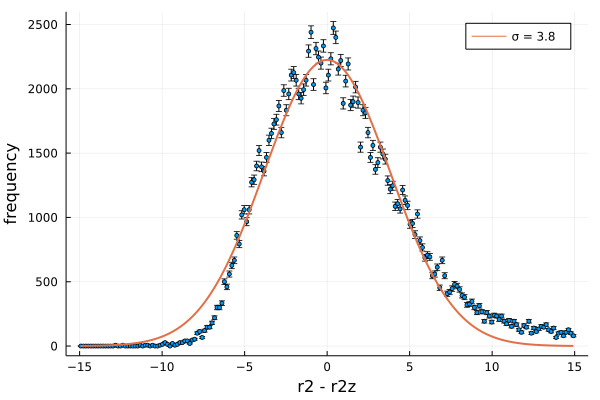

In [36]:
fg,p = fitg1(r2z - ndfz.r2, "r2 - r2z", 200, -15.0, 15.0, xgmin=-10.0, xgmax=10.0)
@printf " σ = %7.1f mm" fg.std[1] 
ANema.pout(p,joinpath(pathp, "zstd-fitg1-r2"))
plot(p)

In [37]:
println("number of  events recorded ", nrow(ndf))
println("number of  events q ϵ (qmin, qmax) ", nrow(ndfq))
println("number of  events zstd ϵ (zstd_min, zstd_max) ", nrow(ndfz))


number of  events recorded 72773
number of  events q ϵ (qmin, qmax) 25202
number of  events zstd ϵ (zstd_min, zstd_max) 22381


## Resolution in (x,y,z,r) intrinsic

 σx =     1.9 mm σy =     1.9 mm σz =     1.3 mm

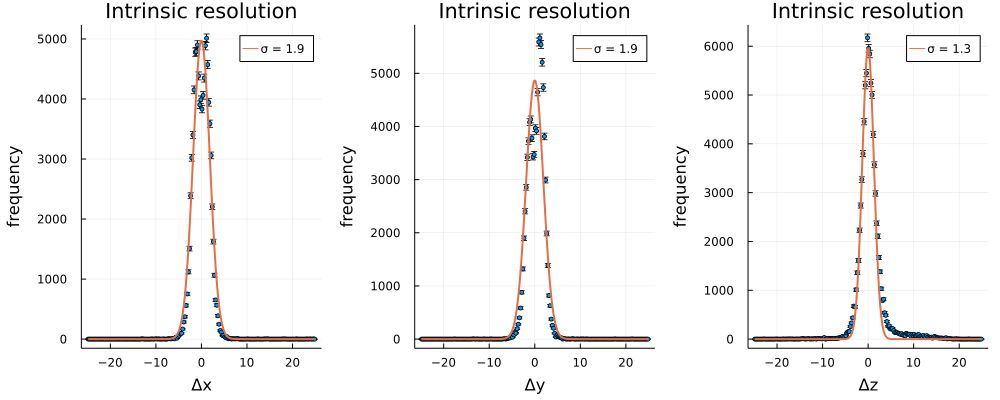

In [40]:
fg,px = fitg1(ndfz.xt1 - ndfz.x1, "Δx", 200, -25.0, 25.0, xgmin=-15., xgmax=15.)
@printf " σx = %7.1f mm" fg.std[1]
fg,py = fitg1(ndfz.yt1 - ndfz.y1, "Δy", 200, -25.0, 25.0, xgmin=-15., xgmax=15.)
@printf " σy = %7.1f mm" fg.std[1]
fg,pz = fitg1(ndfz.zt1 - ndfz.z1, "Δz", 200, -25.0, 25.0, xgmin=-1.5, xgmax=1.5)
@printf " σz = %7.1f mm" fg.std[1]
ANema.plot_and_save(px,py, pz, "Intrinsic resolution", joinpath(pathp, "Intrinsic-res")) 

## Resolución reco

## Position from best estimator (r1p)

In [43]:
xz1,yz1,zz1 = ANema.radial_correction(ndfz.xr1, ndfz.yr1, ndfz.zr1, r1z);
xz2,yz2,zz2 = ANema.radial_correction(ndfz.xr2, ndfz.yr2, ndfz.zr2, r2z);

 σx1 =  2.46 mm σy1 =  2.55 mm σz =  1.43 mm

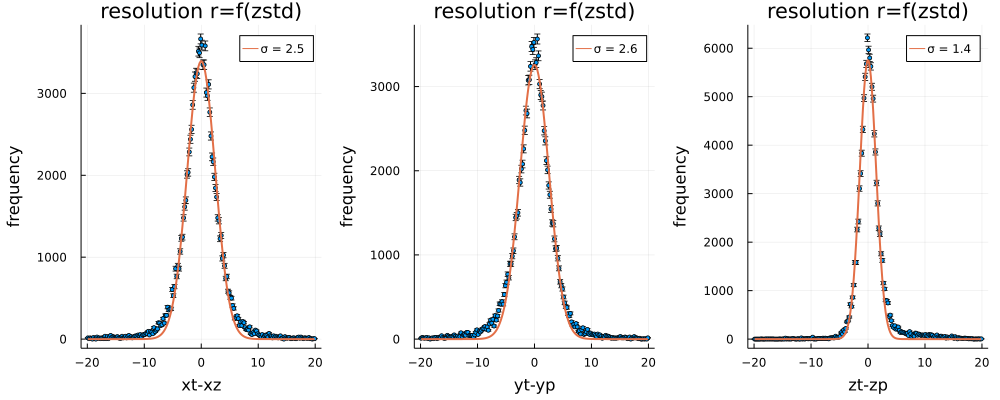

In [44]:
fg,pzx1 = fitg1(ndfz.xt1 - xz1, "xt-xz", 200, -20.0, 20.0, xgmin=-10.0, xgmax=10.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy1 = fitg1(ndfz.yt1 - yz1, "yt-yp", 200, -20.0, 20.0, xgmin=-10.0, xgmax=10.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz1 = fitg1(ndfz.zt1 - zz1, "zt-zp", 200, -20.0, 20.0, xgmin=-10.0, xgmax=10.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx1,pzy1, pzz1, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r1")) 

 σx1 =  2.40 mm σy1 =  2.54 mm σz =  1.40 mm

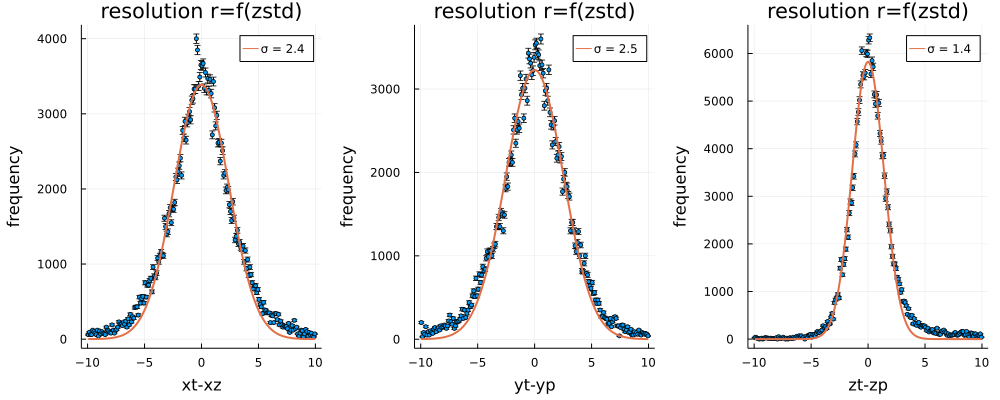

In [46]:
fg,pzx2 = fitg1(ndfz.xt2 - xz2, "xt-xz", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σx1 = %5.2f mm" fg.std[1] 
fg,pzy2 = fitg1(ndfz.yt2 - yz2, "yt-yp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σy1 = %5.2f mm" fg.std[1] 
fg,pzz2 = fitg1(ndfz.zt2 - zz2, "zt-zp", 200, -10.0, 10.0, xgmin=-5.0, xgmax=5.0)
@printf " σz = %5.2f mm" fg.std[1]
ANema.plot_and_save(pzx2,pzy2, pzz2, "resolution r=f(zstd)", joinpath(pathp, "zstd-res-r2")) 

## Summary: resolution in (X,Y,Z):
- Resolution in Z is very good, not affected by radial corrections.
- Resolution in (X,Y) depends on r estimator resolution, and is much worse for all events.

In [47]:
@printf "typical resolution (FWHM) = %5.2f" 2.3 * fg.std[1]

typical resolution (FWHM) =  3.22

In [48]:
2.5 * 2.2

5.5

In [49]:

ndfz[!,"r1x"] = r1z;
ndfz[!,"r2x"] = r2z;

In [50]:
println("number of  events zstd ϵ (zstd_min, zstd_max) ", nrow(ndfz))


number of  events zstd ϵ (zstd_min, zstd_max) 22381


In [51]:
println("fraction of  events zstd ϵ (zstd_min, zstd_max) ", nrow(ndfz) / norm)

fraction of  events zstd ϵ (zstd_min, zstd_max) 0.022381


## TOF

In [55]:
dfz = ANema.setunits(ndfz);

In [56]:
dt12 = ANema.deltatime(dfz, ANema.dtfirst);

In [57]:
t12 = dt12./ps;

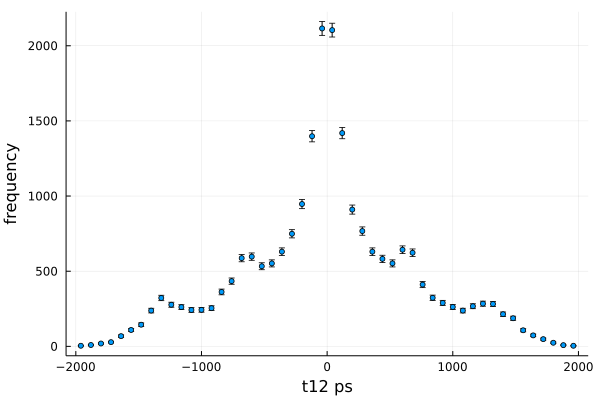

In [58]:
h,p       = hist1d(t12, "t12 ps", 50,  -2000., 2000.)
plot(p)

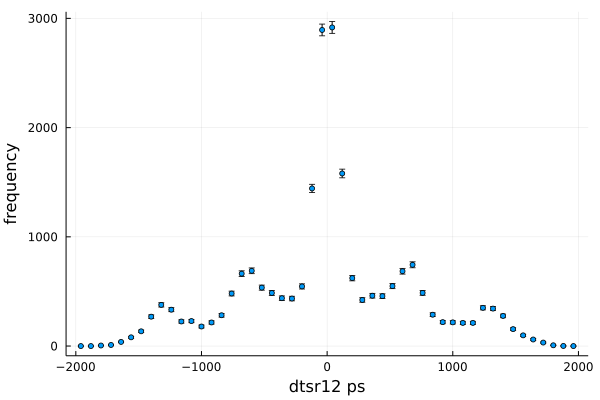

In [60]:
dtsr12 = ANema.ctsr(dfz, ANema.postrue)
tsr12 = dtsr12./ps
h,p       = ANema.hist1d(tsr12, "dtsr12 ps", 50,  -2000., 2000.)
plot(p)

 mean t12 = -4.79 std = 179.88

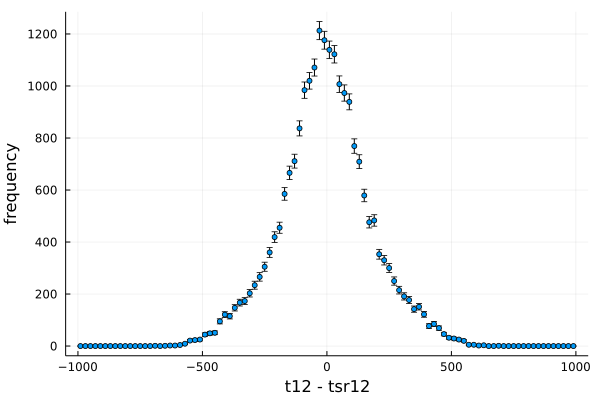

In [61]:
h,p       = hist1d(t12-tsr12, "t12 - tsr12", 100,  -1000., 1000.)
@printf " mean t12 = %5.2f std = %5.2f" mean(t12 - tsr12) std(t12 -tsr12)
plot(p)

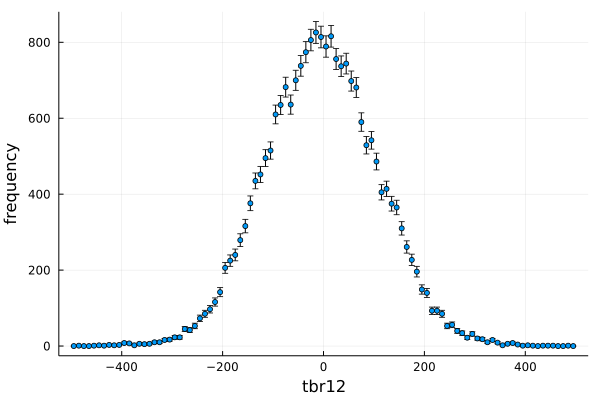

In [62]:
dtrb12 = ANema.cdoi(dfz,  ANema.postrue);
trb12  = dtrb12 ./ps
h,p    = hist1d(trb12, "tbr12", 100,  -500., 500.)
plot(p)

 mean t12 = -0.91 std = 134.11

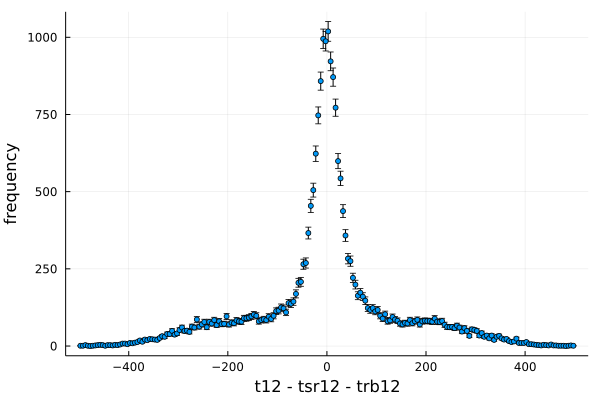

In [63]:
@printf " mean t12 = %5.2f std = %5.2f" mean(t12 - tsr12 - trb12) std(t12 - tsr12 - trb12)
h,p       = hist1d(t12 - tsr12 - trb12  , "t12 - tsr12 - trb12", 200,  -500., 500.)
plot(p)

sigma1 = 195.532 sigma2 =  23.141

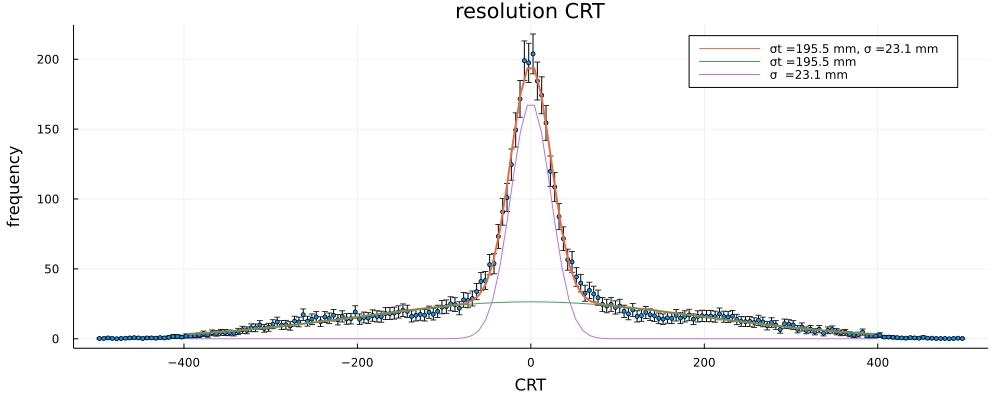

In [64]:
dt = t12 - tsr12 - trb12;
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "sigma1 = %7.3f sigma2 = %7.3f" fg.std[1] fg.std[2]
ANema.plot_and_save(p, "resolution CRT", joinpath(pathp, "CRT")) 

First photon, position true: FWHM1 = 449.723 FWHM2 =  53.225

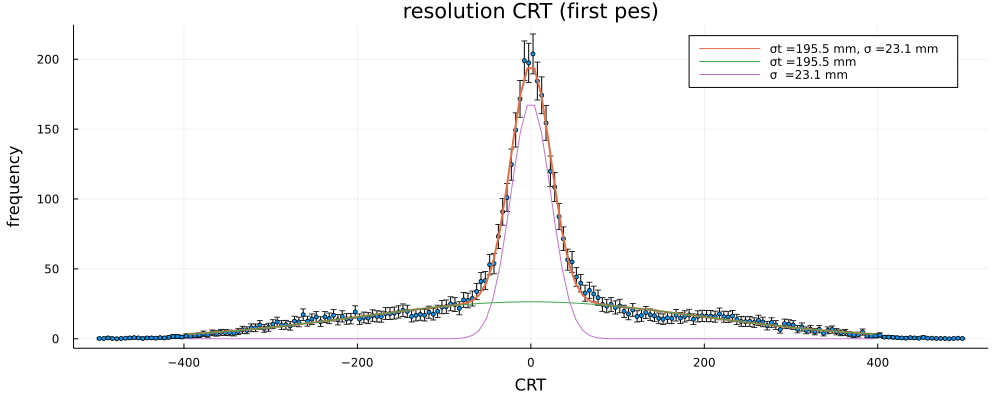

In [65]:
dt = ANema.crt(dfz,  ANema.dtfirst, ANema.postrue)
fg, p = fitg2(dt, "CRT", 200, -500.0, 500.0, 
                      xg1min=-400.0, xg1max=-50.0, 
                      xg2min=-50.0,  xg2max =50.0, 
                      xgmin =-400.0, xgmax  =400.0)
@printf "First photon, position true: FWHM1 = %7.3f FWHM2 = %7.3f" 2.3*fg.std[1] 2.3*fg.std[2]
ANema.plot_and_save(p, "resolution CRT (first pes)", joinpath(pathp, "CRT-first")) 

fastest photoelectron, position reco: FWHM = 240.259

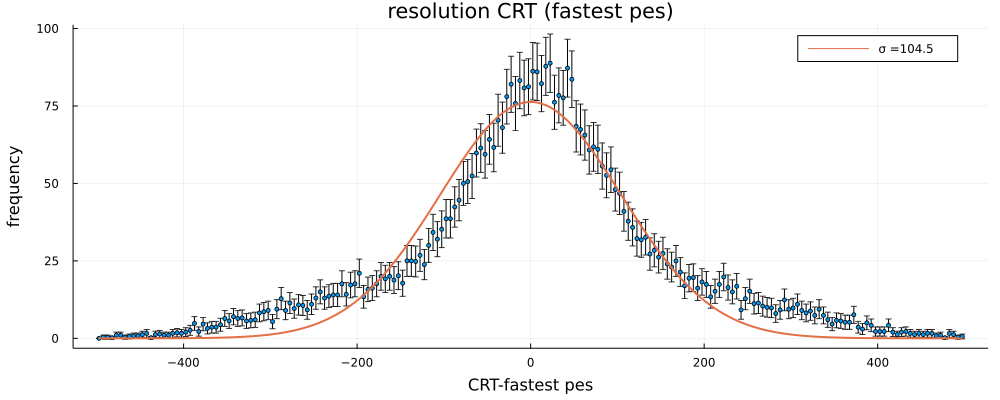

In [66]:
dt = ANema.crt(dfz, ANema.dtminimum, ANema.postrue)
fg,p = fitg1(dt.+10.0, "CRT-fastest pes", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes)", joinpath(pathp, "CRT-fastest")) 

fastest photoelectron, position reco: FWHM = 257.129

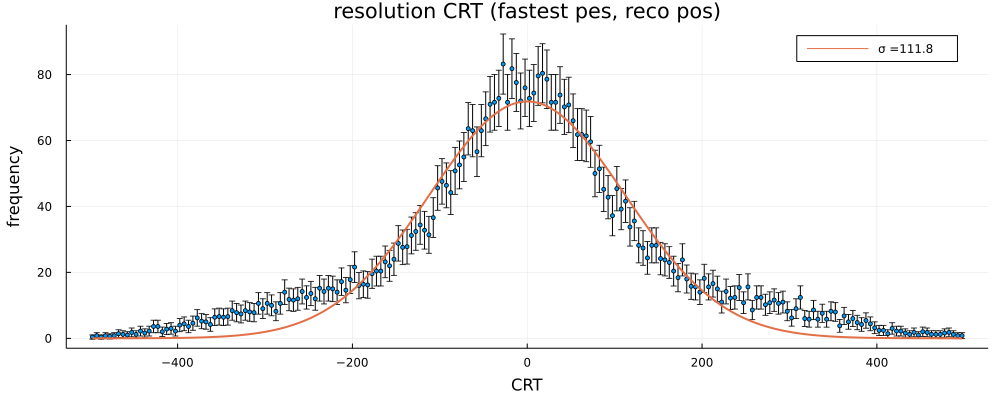

In [67]:
dt = ANema.crt(dfz,  ANema.dtminimum, ANema.posrecall)
fg,p = fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "fastest photoelectron, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (fastest pes, reco pos)", joinpath(pathp, "CRT-fastest-reco")) 

average photoelectrons, position reco: FWHM = 393.575

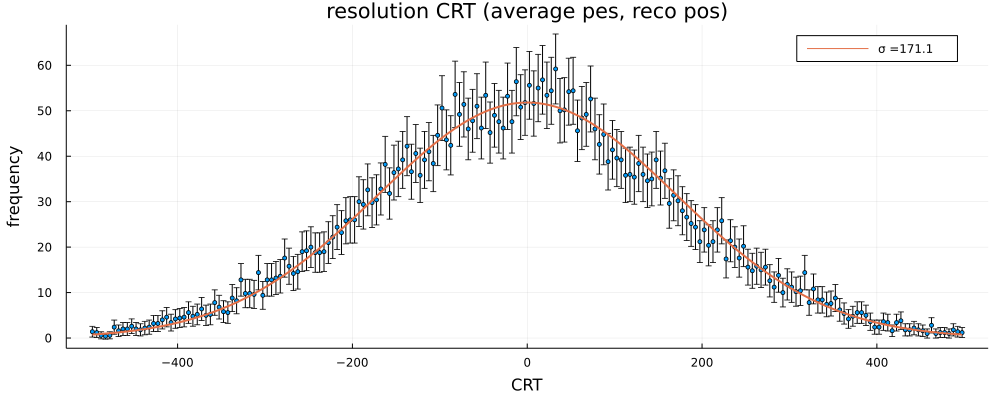

In [68]:
dt = ANema.crt(dfz,  ANema.dtaverage, ANema.posrecall)
fg,p = fitg1(dt, "CRT", 200, -500.0, 500.0,  
                     xgmin=-400.0, xgmax=400.0)
@printf "average photoelectrons, position reco: FWHM = %7.3f" 2.3*fg.std[1] 
ANema.plot_and_save(p, "resolution CRT (average pes, reco pos)", joinpath(pathp, "CRT-average-reco")) 

## Add rx1p and rx2p

In [101]:
println(names(ndfz))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2", "r1x", "r2x"]


In [102]:
println(names(ndfp))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2", "r1x", "r2x"]


In [80]:
println("number of  events zstd ϵ (zstd_min, zstd_max) ", nrow(ndfz))
println("number of  events phistd ϵ (phistd_min, phistd_max) ", nrow(ndfp))

number of  events zstd ϵ (zstd_min, zstd_max) 266962
number of  events phistd ϵ (phistd_min, phistd_max) 216227


In [86]:
println(names(ndfz))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2", "r1x", "r2x"]


In [87]:
println(names(ndfp))

["nsipm1", "nsipm2", "phistd1", "phistd2", "q1", "q2", "r1", "r2", "t1", "t2", "ta1", "ta2", "tr1", "tr2", "ux", "uy", "uz", "x1", "x2", "xb1", "xb2", "xr1", "xr2", "xs", "xt1", "xt2", "y1", "y2", "yb1", "yb2", "yr1", "yr2", "ys", "yt1", "yt2", "z1", "z2", "zb1", "zb2", "zr1", "zr2", "zs", "zstd1", "zstd2", "zt1", "zt2", "r1x", "r2x"]


## Save

In [89]:
ANema.writemdf(patho,"mdf-phistd-$conf.csv", ndfp)


"../data/n3-w-20mm-all-mdf/mdf-phistd-n3-w-20mm-all.csv"

In [90]:
ANema.writemdf(patho,"mdf-zstd-$conf.csv", ndfz)

"../data/n3-w-20mm-all-mdf/mdf-zstd-n3-w-20mm-all.csv"